## Final Project Submission

Please fill out:
* Student name: Jessica Forrest-Baldini
* Student pace: Part-time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as date
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('kc_house_data.csv') 
df = pd.DataFrame(data)
#df.head()

## Clean Data

In [2]:
# Drop yr_renovated - only 744 homes renovated
# Drop waterfront - only 146 homes with waterfronts
# Drop view - this represent if the property has been viewed
# Drop id

to_drop = ['yr_renovated','waterfront','view','id']
df = df.drop(to_drop, axis=1)

In [3]:
# Replace NaN basement values with 0 as there are only 454 of them 
# Test median values for these later to see if it improves model

df.sqft_basement = df.sqft_basement.replace('?','0.0').astype(float)
#df.sqft_basement = df.sqft_basement+1

In [4]:
# Take abs of longitude for normalization later on
df.long = abs(df.long)

8317


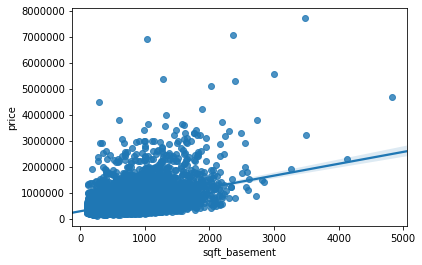

In [5]:
#print(df.sqft_basement.describe())
#df.sqft_basement.value_counts()
#df[df.sqft_basement > 100].sort_values(by='sqft_basement', ascending=True).head(20)
print(sum(df.sqft_basement > 0))
#sns.regplot(df.sqft_basement,df.price);
sns.regplot(df[df.sqft_basement >= 110].sqft_basement,df[df.sqft_basement >= 110].price);

Only 8,317 of the 32,000+ homes have basements, so we're going to bin them. I used zero as one bin and then did a quartile split for all the 'sqft_basement' values for homes with basements. 

In [6]:
# # Bin 'sqft_basement' starting at the min square footage for homes with a basement
# bins = pd.qcut(df.sqft_basement[df.sqft_basement >= 110],q=4)
# bins.value_counts()

In [7]:
# Bin sqft_basement

bins_sqft_basement = [0,109,450,980,5000]

# Bin data & return dummies
def binned_dummies(data, features, bins):
    data_bins = pd.cut(data, bins)
    data_bins = data_bins.cat.as_unordered()
    dummies = pd.get_dummies(data_bins, prefix = features, drop_first=True)
    return dummies

dummies_sqft_basement = binned_dummies(df.sqft_basement,'sqft_basement', bins_sqft_basement)

# Remove original column from data set
df = df.drop(['sqft_basement'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_sqft_basement], axis=1)

In [8]:
# plt.hist(df.grade);

In [9]:
# plt.hist(df.condition);

In [10]:
# df.condition.describe()

In [11]:
# plt.hist(df.long);

In [12]:
# Define function to convert datestr to datenum
def datenum(datestr):
    '''
    Convert datestring in the format MM/DD/YYYY
    to MATLAB style datenum
    '''
    datenum = date.toordinal(date((int(datestr.split('/', -1)[2])),
                                  (int(datestr.split('/', -1)[0])),
                                  (int(datestr.split('/', -1)[1]))
                                 ))+366
    return datenum

# Apply to date column
df.date = df.date.map(datenum)

Explore the data and check for any outliers.

In [13]:
# round(df.describe(),1)

We can see here that bedrooms has what seems to be a major outlier, 33 bedrooms. Let's take a deeper look. 

In [14]:
# # Compare with other homes in data set that have high number of bedrooms
# df[df.bedrooms > 9] 

In [15]:
# 33 bedrooms and only 1.75 bathrooms doesn't seem right. It is a pretty big lot at 6,000sqft
# but 33 bedrooms doesn't seem right. Remove. 

to_drop = df[df.bedrooms == 33].index
df = df.drop(to_drop)

'sqft_lot' seems to have a major outlier at 1,651,359 sqft. Let's take a closer look.

In [16]:
# print(df.sqft_lot.median())
# display(df.sort_values(by='sqft_lot', ascending=False).head(5))

This appears to be the highest, but not necessarily an outlier. Let's go ahead and leave it for now. 

In [17]:
# df.long.describe()

In [18]:
# plt.hist(df.long);

## Normalize, MinMax Scale, Standardize, 
One-Hot Encode

First, check for normality, heteroscedasticity & discover categorical data. Can get a good idea of categorical features from looking at the data above, but let's explore normality, categorical and any relationships using a pairplot.

In [19]:
# Commented out because takes a long time to run
#sns.pairplot(df)

While 'condition' and 'grade' are technically categorical, they are on a scale, so I am going to leave them as is, and will min-max scale them. 

In [20]:
# features = ['date','price','sqft_living', 'bedrooms','bathrooms',
#             'lat','long','floors','condition','grade','sqft_living',
#             'sqft_lot','sqft_above','yr_built',
#             'sqft_living15','sqft_lot15','zipcode']

In [21]:
# Normalize Data

# Log Transform 

# Continuous variables
features = ['date','price','sqft_living','lat','long', #'sqft_basement',
            'sqft_lot','sqft_above','yr_built',
            'sqft_living15','sqft_lot15','zipcode']

df_cont_features = df[features]

# Add '_log' to continuous variable column names
log_names = [f'{column}_log' for column in df_cont_features.columns]

# Log transform continuous variables
df_log = np.log(df_cont_features)
df_log.columns = log_names


### Normalize (subract mean and divide by std)

# Define function to normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# Apply function to normalize
df_log_norm = df_log.apply(normalize)

# # Define function to min-max scale
# def minmaxscale(feature):
#     return (feature-min(feature))/(max(feature)-min(feature))

# # Apply function to min-max scale
# df_log_norm_scale = df_log.apply(minmaxscale)

# Remove original column from data set
df = df.drop(features, axis=1)

# Add new columns in
df = pd.concat([df, df_log_norm], axis=1) #_scale

In [22]:
# df.head()

## Check for Multicollinearity 

### Multicollinearity

In [23]:
# Take a look at the correlation matrix to check for multicollinearity
abs(df.corr()) > 0.75

,bedrooms,bathrooms,floors,condition,grade,"sqft_basement_(109, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]",date_log,price_log,sqft_living_log,lat_log,long_log,sqft_lot_log,sqft_above_log,yr_built_log,sqft_living15_log,sqft_lot15_log,zipcode_log
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
floors,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(109, 450]",False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(450, 980]",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(980, 5000]",False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
date_log,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
price_log,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [24]:
# # Check & see if sqft_lot15 & sqft_living15 are correlated with sqft_lot & sqft_living
# sns.regplot(df.sqft_lot,df.sqft_lot15)
# plt.show()
# sns.regplot(df.sqft_living,df.sqft_living15)
# plt.show()

We can see that 'sqft_lot15' & 'sqft_living15' are correlated with 'sqft_lot' & 'sqft_living', which makes sense because the features appended with 15 represent the average of the 15 nearest neighbors. 

We will remove these values to prevent multicollinearity in our model. 

In [25]:
# # Remove sqft_lot15 & sqft_living15
# df = df.drop(['sqft_lot15','sqft_living15'], axis=1)

In [26]:
# # Take a look at the correlation matrix to check for multicollinearity
# df.corr() > 0.75

We can see here that 'sqft_living' seems to be highly correlated with multiple features such as 'bathrooms', 'grade', and 'sqft_above'. 'sqft_living' represents the square footage of the entire home and seems that it would be a strong indicator of home price. The squarefoot of other features are essentially subsets of the overall home squarefootage. So for now I am going to remove it. However, it could be kept in place and other features removed later on to see if this improves the overall performance of the model.

In [27]:
# # Remove 'sqft_living' to prevent multicollinearity 
# # as it is highly correlated with multiple features

# df = df.drop(['sqft_living'], axis=1)

In [28]:
# abs(df.corr()) > 0.75

It looks like 'sqft_above' and 'grade' are highly correlated, so we should only keep one to prevent multicollinearity. 

For now I'm going to keep 'sqft_above', but can also test removing 'sqft_above' and one-hot-encoding 'grade' later on to see if it improves performance of the model. 

In [29]:
# # We can see the relationship here between 'sqft_above' and 'grade', it appears to possibly
# # be polynomial. While grade is categorical, it is continuous
# sns.regplot(df.grade,df.sqft_above);

Since the relationship looks slightly polynomial, and 'grade' technically is categorical, I want to look at their distributions to further explore the relationship. Let's look at the histograms/distplot.

In [30]:
# sns.distplot(df.sqft_above)
# plt.show()
# plt.hist(df.grade)
# plt.show()

Both do appear to be skewed in the same direction, so perhaps they are linearly related. Okay, I will remove grade. 

In [31]:
# df = df.drop(['grade'], axis=1)

In [32]:
# df.head()

## Start Modeling

### Split train/test datasets

In [33]:
# Separate target and feature variables

X = df.drop(['price_log'],axis=1)
y = df.price_log

In [34]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split data with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Fit Model

In [35]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model class
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

# Calculate predictions on test set
y_hat_test = linreg.predict(X_test)

### Cross Validate Model

In [36]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

# Test Errors Results
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.4927516818843157


In [37]:
from sklearn.model_selection import KFold

crossval = KFold(n_splits=3, shuffle=True, random_state=1)

baseline_R2 = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossval))
baseline_R2

0.7585535550564227

### Statsmodel (OLS)

In [38]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     3787.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        17:17:50   Log-Likelihood:                -15251.
No. Observations:               21596   AIC:                         3.054e+04
Df Residuals:                   21577   BIC:                         3.069e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.2168      0.050    -64.129      0.000      -3.315      -3.118
bedrooms                     -0.0738      0.005    -14.743      0.000      -0.084      -0.064
bathrooms                     0.1508      0.008     19.222      0.000       0.135       0.166
floors                        0.1079      0.010     11.231      0.000       0.089       0.127
condition                     0.1154      0.006     20.315      0.000       0.104       0.126
grade                         0.3301      0.005     65.112      0.000       0.320       0.340
sqft_basement_(109, 450]      0.1603      0.015     10.827      0.000       0.131       0.189
sqft_basement_(450, 980]      0.1288      0.019      6.612      0.000       0.091       0.167
sqft_basement_(980, 5000]     0.2547      0.026      9.622      0.000       0.203       0.307
date_log                      0.0431      0.003     12.861      0.000       0.037       0.050
sqft_living_log               0.1450      0.019      7.624      0.000       0.108       0.182
lat_log                       0.3500      0.004     96.392      0.000       0.343       0.357
long_log                      0.0361      0.005      7.878      0.000       0.027       0.045
sqft_lot_log                  0.0295      0.009      3.352      0.001       0.012       0.047
sqft_above_log                0.1312      0.018      7.272      0.000       0.096       0.167
yr_built_log                 -0.2404      0.005    -49.241      0.000      -0.250      -0.231
sqft_living15_log             0.1518      0.006     27.129      0.000       0.141       0.163
sqft_lot15_log               -0.0519      0.009     -6.037      0.000      -0.069      -0.035
zipcode_log                  -0.0507      0.004    -11.811      0.000      -0.059      -0.042
==============================================================================
Omnibus:                      505.122   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              907.122
Skew:                           0.190   Prob(JB):                    1.05e-197
Kurtosis:                       3.930   Cond. No.                         146.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interactions

In [39]:
from itertools import combinations

# Find top interactions by R^2 value

# Use combinations from itertools to create all possible combinations of two features
feat_combinations = combinations(X_train.columns, 2)

# Empty list to fill for interactons values
interactions = []

# for i, (feature1,feature2) in feature_combinations:
for i, (a, b) in enumerate(feat_combinations):
    # fill interatctions list with feature a * feature b
    X_train['interaction'] = X_train[a] * X_train[b]
    R2 = np.mean(cross_val_score(linreg, X_train, y_train, scoring='r2', cv=crossval))
    if R2 > baseline_R2:
        interactions.append((a, b, round(R2,5)))
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Top 3 interactions: [('lat_log', 'sqft_lot15_log', 0.76464), ('lat_log', 'sqft_lot_log', 0.7641), ('long_log', 'zipcode_log', 0.76253)]


# Best Performing Model - So Far

In [40]:
#Build a final model with interactions
#Use 10-fold cross-validation to build a model using the above interaction.

crossval = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['lat_log*sqft_lot15_log'] = final['lat_log'] * final['sqft_lot15_log']
final['lat_log*sqft_lot_log'] = final['lat_log'] * final['sqft_lot_log']
final['long_log*zipcode_log'] = final['long_log'] * final['zipcode_log']

final['lat*long'] = final['lat'] * final['long']

final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

KeyError: 'lat'

In [ ]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

In [ ]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)